In [1]:
import numpy as np
import matplotlib.pyplot as plt #for displaying plots
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras.layers import *
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import *
from keras.callbacks import *
from keras import regularizers
from keras.utils import plot_model

from tensorflow.keras.saving import register_keras_serializable

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import datetime
import random
import properscoring as ps

from scipy.stats import norm
from scikeras.wrappers import KerasRegressor

import xgboost
import pydot
import graphviz

from keras.models import load_model
from sklearn.multioutput import MultiOutputRegressor
import pickle

from sklearn.model_selection import ParameterGrid
from pathlib import Path
import joblib
import shap
from sklearn.model_selection import cross_val_score

# Setup

## Basic Setup

In [2]:
# setting a seed to ensure reproducability and consistency
random.seed(16)
np.random.seed(16)
tf.random.set_seed(16)

In [ ]:
plt.rcParams.update({'font.size': 13})

In [3]:
X_train = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\X_train_final.pkl")
X_valid = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\X_valid_final.pkl")
X_test = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\X_test_final.pkl")

X_train_all = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\X_train.pkl")
X_valid_all = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\X_valid.pkl")
X_test_all = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\X_test.pkl")

y_train = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\y_train.pkl")
y_valid = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\y_valid.pkl")
y_test = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\y_test.pkl")


In [4]:
X_train_all['date'] =  pd.to_datetime(X_train_all['date'])
X_valid_all['date'] =  pd.to_datetime(X_valid_all['date'])
X_test_all['date'] =  pd.to_datetime(X_test_all['date'])

In [5]:
X_train.head()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
0,-0.039776,-0.397192,0,1,2,1.0,0.0,0.0,0.0,-0.218119,-0.031329,0
1,0.244625,-0.397192,0,1,3,1.0,0.0,0.0,0.0,-0.324284,-0.458165,0
2,0.381694,-0.371451,0,1,4,1.0,0.0,0.0,0.0,-1.076810,0.254435,0
3,1.300863,-0.397192,0,0,5,1.0,0.0,0.0,0.0,-0.405469,1.357699,0
4,0.745990,0.555250,0,0,6,1.0,0.0,0.0,0.0,0.297096,0.059103,0


In [6]:
X_valid.tail()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
359,-1.064496,-0.397192,0,1,1,0.0,0.0,0.0,1.0,-0.258711,-0.353265,1
360,-0.478837,-0.397192,0,1,2,0.0,0.0,0.0,1.0,1.087091,-0.823509,1
361,-0.104279,0.143383,0,1,3,0.0,0.0,0.0,1.0,2.276769,-0.913940,1
362,-0.691404,0.169125,0,1,4,0.0,0.0,0.0,1.0,-0.674006,-0.508807,1
363,0.541485,-0.397192,0,0,5,0.0,0.0,0.0,1.0,1.564836,-0.201340,1


In [7]:
y_test.head()

0    1160.0
1    2996.0
2    3635.0
3    3265.0
4    3751.0
Name: bike_count, dtype: float64

In [8]:
X_train.shape, X_valid.shape, X_test.shape

((3161, 12), (364, 12), (390, 12))

In [9]:
y_train.shape, y_valid.shape, y_test.shape

((3161,), (364,), (390,))

In [10]:
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [11]:
y_train.shape, y_valid.shape, y_test.shape

((3161,), (364,), (390,))

In [12]:
X_train.isna().sum()

temperature                 0
precipitation               0
public_holiday_indicator    0
is_workday                  0
day_of_week                 0
spring                      0
summer                      0
autumn                      0
winter                      0
windspeed                   0
sun                         0
school_holiday_indicator    0
dtype: int64

In [13]:
X_train.dtypes

temperature                 float64
precipitation               float64
public_holiday_indicator      int64
is_workday                    int64
day_of_week                   int64
spring                      float64
summer                      float64
autumn                      float64
winter                      float64
windspeed                   float64
sun                         float64
school_holiday_indicator      int64
dtype: object

In [14]:
X_train.describe()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
count,3.161000e+03,3.161000e+03,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3.161000e+03,3.161000e+03,3161.000000
mean,4.450726e-16,3.708939e-17,0.033534,0.684910,3.001898,0.243277,0.259412,0.259095,0.238216,4.832859e-17,4.720467e-17,0.232521
std,1.000158e+00,1.000158e+00,0.180054,0.464625,2.001106,0.429129,0.438381,0.438207,0.426059,1.000158e+00,1.000158e+00,0.422506
min,-2.660948e+00,-3.971923e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.513961e+00,-1.094803e+00,0.000000
25%,-7.932892e-01,-3.971923e-01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-7.364558e-01,-9.899026e-01,0.000000
50%,-9.270793e-04,-3.971923e-01,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,-2.056287e-01,-2.085744e-01,0.000000
75%,7.907021e-01,-1.140338e-01,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,0.000000,4.969366e-01,8.585175e-01,0.000000
max,2.566737e+00,1.461021e+01,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,4.952762e+00,2.193287e+00,1.000000


## Functions

In [15]:
def add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, col_name):
    
    X_train_num[col_name] = X_train[col_name]
    X_valid_num[col_name] = X_valid[col_name]
    X_test_num[col_name] = X_test[col_name]
    
    return X_train_num, X_valid_num, X_test_num

In [16]:
def crps_normal_cost_function(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]
    
    # Split input
    mu = y_pred[:, 0]
    var = tf.square(y_pred[:, 1]) # Ensure standard deviation is positive
    sigma = tf.sqrt(var)  
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [17]:
def crps_normal_cost_function_v2(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]

    # Split input
    mu = y_pred[:, 0]
    sigma = tf.math.softplus(y_pred[:, 1])  # Apply softplus to ensure positive std
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [18]:
def predict_and_calculate_mean_crps(model, X_test = X_test, y_test = y_test, print_predicted_mean_std = False):
    """Make predictions on test data and calculate mean CRPS.

    Args:
        model: Trained model
        X_test: Test data
        y_test: True values
        print_predicted_mean_std: Boolean to print predicted mean and std

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
     
    predicted_mean_std = model.predict(X_test)
    if print_predicted_mean_std:
        print(predicted_mean_std)
    
    predicted_mean = predicted_mean_std[:, 0]
    predicted_std = predicted_mean_std[:, 1]
    crps_values = ps.crps_gaussian(y_test, mu=predicted_mean, sig=predicted_std)

    mean_crps = np.mean(crps_values)
    print(f"\nMean CRPS: { mean_crps }")


    return mean_crps, predicted_mean_std, crps_values

In [19]:
def compile_and_fit_model(model, X_train = X_train, y_train = y_train, X_valid = X_valid, y_valid = y_valid,  pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10):
    """Compile and fit a model on training data.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size

    Returns:
        model: Trained model
    """

    #print some information about the model
    print('Model information:\n\nCallbacks: EarlyStopping (patience: ' + str(pat) + '), Learning Rate (Reduce on Plateau, patience: ' + str(pat) + ')\nBatch size: ' + str(batch_size) + '\nEpochs: ' + str(epochs) + '\n')
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=pat, 
                                                      restore_best_weights=True)
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.2,
                                                     patience = pat,
                                                     min_lr=0 )
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss_function)

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[early_stopping, reduce_lr])

    return model, history

In [20]:
def plot_loss(history):
    """Plot training and validation loss.

    Args:
        history: History object
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [21]:
def process_model(model, X_train = X_train, y_train = y_train, X_valid = X_valid, y_valid = y_valid,  X_test = X_test, y_test = y_test, pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10, print_predicted_mean_std = False, plot_loss_flag = True):
    """Compile, fit and evaluate a model.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        X_test: Test data
        y_test: Test targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size
        print_predicted_mean_std: Boolean to print predicted mean and std
"""

    model, history = compile_and_fit_model(model, X_train, y_train, X_valid, y_valid,  pat, lr, loss_function, epochs, batch_size)

    mean_crps, predicted_mean_std = predict_and_calculate_mean_crps(model, X_test, y_test, print_predicted_mean_std)

    if plot_loss_flag:
        plot_loss(history)

    return model, mean_crps, history, predicted_mean_std

# Hyperparameter Tuning

## Functions

In [22]:
@register_keras_serializable(package="Custom", name="crps_normal_cost_function")
def crps_normal_cost_function_v3(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    #print("y_true shape2: ", y_true.shape)
    # Split input
    mu = y_pred[:, 0]
    sigma = tf.math.softplus(y_pred[:, 1])  # Apply softplus to ensure positive std
    #sigma = y_pred[:, 1]
    
    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    
     # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))   
    
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps


In [23]:
@register_keras_serializable(package="Custom", name="crps_loss_function_wrapper")  
def crps_loss_function_wrapper(y_true, y_pred, tensor=True):
    """Wrapper for CRPS loss function.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """
    
    if isinstance(y_pred, (pd.DataFrame, pd.Series)):
       y_pred = tf.convert_to_tensor(y_pred.values)

    if isinstance(y_true, (pd.DataFrame, pd.Series)):
        y_true = tf.convert_to_tensor(y_true.values, dtype=tf.float32)
        
    y_pred_reshaped = y_pred.reshape(-1, 2) #Keras Regressor flattens the values so they need to be reshaped

    crps = crps_normal_cost_function_v3(y_true, y_pred_reshaped, tensor)

    crps = crps.numpy()
    
    return crps

In [24]:
def tune_nn(input_shape_in, X_train_in, X_valid_in, X_test_in, y_train_in, y_valid_in, y_test_in, model_in=None, n_neurons=[256], dropout_rate=[0.25], 
            reg_values=[ 0.01], batch_size=[32], learning_rate=[1e-4], n_blocks=[2,4,5,6], epochs = 200, cv=5, n_jobs=1, verbose=10, patience=5):
    """Tune hyperparameters of a neural network using GridSearchCV.

    Args:
        input_shape_in: Number of features
        X_train_in: Training data
        X_valid_in: Validation data
        X_test_in: Test data
        y_train_in: Training targets
        y_valid_in: Validation targets
        y_test_in: Test targets
        model_in: Predefined model
        n_neurons: Number of neurons in hidden layers
        dropout_rate: Dropout rate
        reg_values: Regularization values
        batch_size: Batch size
        learning_rate: Learning rate
        n_blocks: Number of blocks
        epochs: Number of epochs
        cv: Number of cross-validation folds
        n_jobs: Number of jobs
        verbose: Verbosity
        patience: Patience for early stopping


    Returns:
        y_pred: Predictions on test data
        best_model: Best model
        cv_results: Results of cross-validation
    """


    iteration = 0

    # Define Keras model with hyperparameters
    def create_model(n_neurons, dropout_rate, reg_value, n_blocks):
        nonlocal iteration  # Declare iteration as nonlocal
        model = model_in
        input_shape = input_shape_in
        if model is None:
            model = Sequential()
            model.add(Input(shape=(input_shape,)))

            for i in range(n_blocks):
                model.add(Dense(n_neurons, activation='relu', kernel_regularizer=regularizers.l2(reg_value)))
                if i%2 == 0:# add a dropout layer every 2nd layer
                    model.add(Dropout(dropout_rate))
            
            # Output layer with two outputs: mean and std
            model.add(Dense(2, activation='softplus'))
        
        if iteration % cv == 1 or iteration == 0: # don't print for every fold
            model.summary()
        
        iteration += 1
        # only to see that something is happening
        print("Iteration: " + str(iteration))

        
        model.compile(optimizer=tf.keras.optimizers.Adam(), loss=crps_normal_cost_function_v3 )
        return model

    # Define hyperparameters
    param_grid = dict(
       batch_size=batch_size,
       optimizer__learning_rate=learning_rate,
        model__n_neurons=n_neurons,
        model__dropout_rate=dropout_rate,
        model__reg_value=reg_values,
        model__n_blocks=n_blocks
    ) 


    # Create the model
    model = KerasRegressor(model=create_model, epochs=epochs, verbose=0)
    

    my_scorer = make_scorer(crps_loss_function_wrapper, greater_is_better=False) 

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=my_scorer)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    grid_search.fit(X_train_in, y_train_in, validation_data=(X_valid_in, y_valid_in), callbacks=[early_stopping])

    # Access the best hyperparameters and results
    best_params = grid_search.best_params_
    cv_results = pd.DataFrame(grid_search.cv_results_)
    best_model = grid_search.best_estimator_

    # Print the best hyperparameters
    print("Best Hyperparameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    y_pred = best_model.model_.predict(X_test_in)
    predicted_mean = y_pred[:, 0]
    predicted_std = y_pred[:, 1]

    mean_crps = np.mean(ps.crps_gaussian(y_test_in, mu=predicted_mean, sig=predicted_std))
    print(f"\nMean CRPS: { mean_crps }")
    
    return  y_pred, best_model, cv_results, grid_search
    

## Grid Search

In [25]:
#y_pred_tuned, best_model_tuned, cv_results_tuned, grid_search_tuned = tune_nn(X_train.shape[1], X_train, X_valid, X_test, y_train, y_valid, y_test, cv=3 )

## Saving the GridSearch

In [26]:
base_path = Path(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Hyperparameter_Tuning_Ergebnisse")

In [27]:
file_name_grid_search = "grid_search_tuned_v4.pkl"
file_path_grid_search = base_path / file_name_grid_search

#joblib.dump(grid_search_tuned, str(file_path_grid_search))

## Loading the Grid Search

In [28]:
loaded_grid_search_tuned = joblib.load(str(file_path_grid_search))

In [29]:
loaded_grid_search_tuned.best_params_

{'batch_size': 32,
 'model__dropout_rate': 0.25,
 'model__n_blocks': 2,
 'model__n_neurons': 256,
 'model__reg_value': 0.01,
 'optimizer__learning_rate': 0.0001}

In [30]:
loaded_grid_search_tuned.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=3,
             estimator=KerasRegressor(epochs=200, model=<function tune_nn.<locals>.create_model at 0x00000198A3ED93A0>, verbose=0),
             n_jobs=1,
             param_grid={'batch_size': [32], 'model__dropout_rate': [0.25],
                         'model__n_blocks': [2, 4, 5, 6],
                         'model__n_neurons': [256], 'model__reg_value': [0.01],
                         'optimizer__learning_rate': [0.0001]},
             scoring=make_scorer(crps_loss_function_wrapper, greater_is_better=False, response_method='predict'),
             verbose=10)>

### Tests if everything went well

In [31]:
pd.DataFrame(loaded_grid_search_tuned.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_model__dropout_rate,param_model__n_blocks,param_model__n_neurons,param_model__reg_value,param_optimizer__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,46.959154,2.164338,0.168518,0.002673,32,0.25,2,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-436.033295,-365.633362,-456.979004,-419.548553,39.071017,1
1,68.182266,7.563303,0.287832,0.051228,32,0.25,4,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-433.128113,-358.867157,-496.326172,-429.440481,56.177956,2
2,67.854870,4.217442,0.226690,0.004473,32,0.25,5,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-435.055481,-369.775513,-520.652954,-441.827983,61.781338,4
3,71.661458,1.339978,0.266316,0.013437,32,0.25,6,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-438.290680,-382.904663,-487.229218,-436.141520,42.617425,3


In [32]:
loaded_grid_search_tuned.best_index_

0

In [33]:
model = loaded_grid_search_tuned.best_estimator_

In [34]:
loaded_grid_search_tuned.best_score_

-419.5485534667969

In [35]:
mean_crps, predicted_mean_std, crps_values = predict_and_calculate_mean_crps(model.model_, X_test, y_test, print_predicted_mean_std = False)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Mean CRPS: 350.3571886057652


In [36]:
loaded_grid_search_tuned.scorer_

make_scorer(crps_loss_function_wrapper, greater_is_better=False, response_method='predict')

In [37]:
loaded_grid_search_tuned.n_splits_

3

In [38]:
model.model_.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_72 (Dense)                │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,904 (816.04 KB)

 Trainable params: 69,634 (272.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 139,270 (544.03 KB)

In [39]:
predicted_mean_std

array([[ 759.9553 ,  212.5461 ],
       [3669.4036 ,  643.2972 ],
       [3923.2732 ,  639.4913 ],
       [3319.2344 ,  523.89264],
       [3903.426  ,  558.67456],
       [1026.8625 ,  214.23889],
       [2639.4324 ,  437.03427],
       [1281.2133 ,  301.98468],
       [3476.663  ,  625.0038 ],
       [4456.2783 ,  652.93604],
       [3667.1406 ,  598.37036],
       [4445.6436 ,  576.36084],
       [3712.8987 ,  584.1497 ],
       [3155.31   ,  457.79593],
       [1056.9376 ,  238.74983],
       [3386.2144 ,  613.2091 ],
       [4443.408  ,  664.64703],
       [3998.2097 ,  610.28906],
       [4086.421  ,  573.6009 ],
       [4242.8853 ,  621.7147 ],
       [2474.5764 ,  390.6987 ],
       [1266.1732 ,  256.01044],
       [3813.9727 ,  624.2318 ],
       [3964.1614 ,  607.0484 ],
       [4073.8044 ,  597.41455],
       [4108.997  ,  584.7365 ],
       [4096.86   ,  598.45105],
       [2751.4106 ,  422.8869 ],
       [1413.0203 ,  278.18796],
       [3554.112  ,  597.47266],
       [39

In [40]:
y_pred_df = pd.DataFrame(predicted_mean_std)

In [41]:
y_pred_df.describe()

,0,1
count,390.000000,390.000000
mean,4650.952637,644.238159
std,1821.171509,189.986481
min,668.086731,184.482834
25%,3432.036926,540.725006
50%,4698.807617,655.662506
75%,5898.094971,774.519089
max,8049.589355,1006.011902


## Plots

### Residuals etc.

In [42]:
base_path_plots = Path(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Abbildungen\(11) Fahrraddaten_HyperparameterTuning4")

In [43]:
predicted_mean = predicted_mean_std[:, 0]
predicted_std = predicted_mean_std[:, 1]

In [44]:
residuals = y_test - predicted_mean

In [45]:
file_name_residuals_hist = "residuals_hist.png"
file_path_residuals_hist = base_path_plots / file_name_residuals_hist

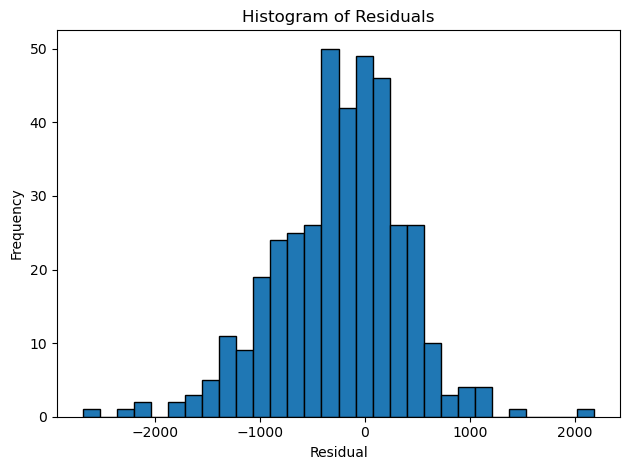

In [46]:
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.gcf().savefig(file_path_residuals_hist)
plt.show()


In [47]:
residuals.describe()

count     390.000000
mean     -234.628756
std       609.247266
min     -2690.934082
25%      -613.416992
50%      -180.281677
75%       147.584869
max      2189.215332
Name: bike_count, dtype: float64

In [48]:
top_5_residuals = residuals.nlargest(5)
print(top_5_residuals)

353    2189.215332
352    1533.121094
338    1174.214844
351    1122.749512
346    1120.098877
Name: bike_count, dtype: float64


In [49]:
residuals[5]

547.137451171875

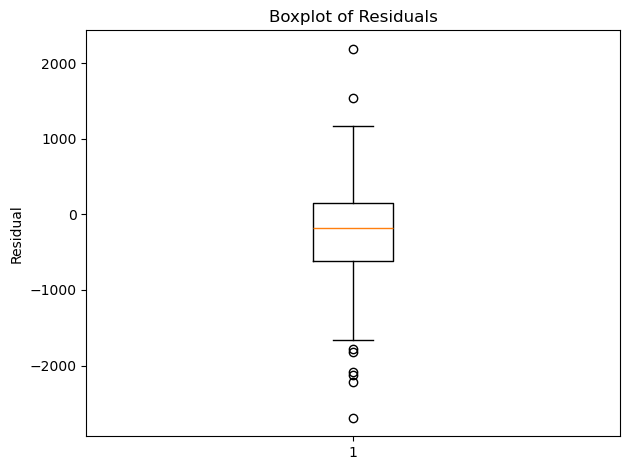

In [50]:
file_name_boxplot_residuals = "boxplot_residuals.png"
file_path_boxplot_residuals = base_path_plots / file_name_boxplot_residuals

boxplot_residuals = plt.boxplot(residuals)
plt.title("Boxplot of Residuals")
plt.ylabel("Residual")
plt.tight_layout()
plt.gcf().savefig(file_path_boxplot_residuals)
plt.show()



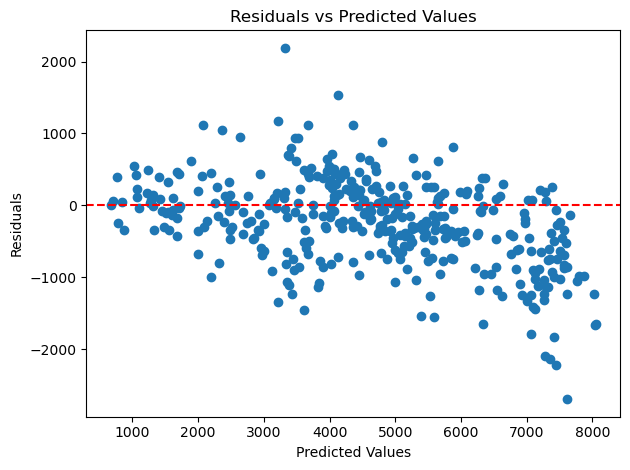

In [51]:
file_name_res_vs_pred_plot = "res_vs_pred_plot.png"
file_path_res_vs_pred_plot = base_path_plots / file_name_res_vs_pred_plot

res_vs_pred_plot = plt.scatter(predicted_mean, residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Horizontale Linie bei 0
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.gcf().savefig(file_path_res_vs_pred_plot)
plt.show()


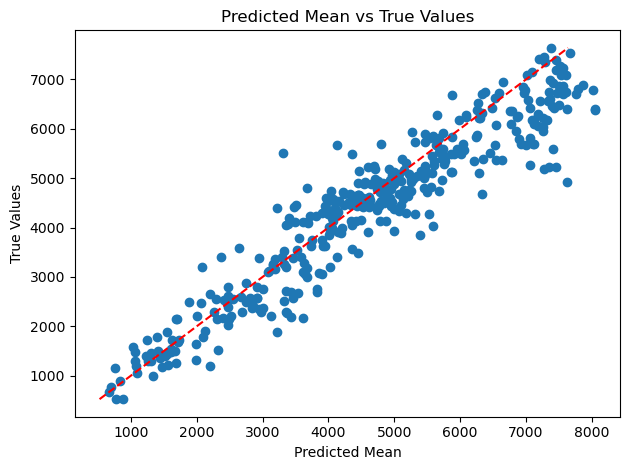

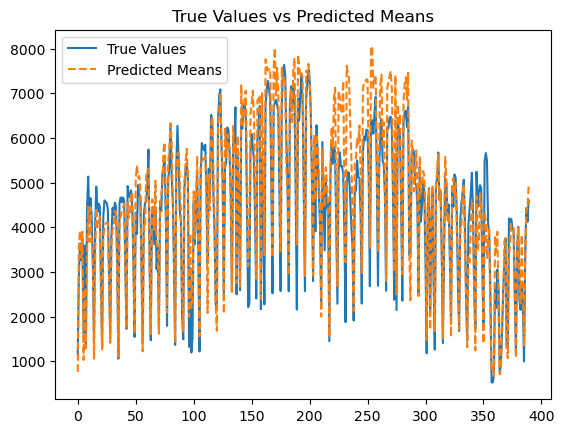

In [52]:
# Scatter plot
plt.scatter(predicted_mean, y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Predicted Mean vs True Values")
plt.xlabel("Predicted Mean")
plt.ylabel("True Values")

file_name_scatter_plot = "scatter_plot.png"
file_path_scatter_plot = base_path_plots / file_name_scatter_plot
plt.tight_layout()  
plt.gcf().savefig(file_path_scatter_plot)
plt.show()

# Line plot
plt.plot(y_test, label="True Values")
plt.plot(predicted_mean, label="Predicted Means", linestyle='--')
plt.legend()
plt.title("True Values vs Predicted Means")
plt.show()


In [53]:
standardized_residuals = residuals / predicted_std

standardized_residuals_df = pd.DataFrame(standardized_residuals)

In [54]:
standardized_residuals_df.describe()

,bike_count
count,390.000000
mean,-0.283519
std,0.954448
min,-2.779152
25%,-0.915076
50%,-0.293032
75%,0.272638
max,3.848483


In [55]:
standardized_residuals_df
max_index = np.argmax(np.abs(standardized_residuals))
print(f"Index of max column: {max_index}")

Index of max column: 353


In [56]:
index_2largest_residual = 353

In [57]:
standardized_residuals.nlargest(5)

353    3.848483
287    2.921906
112    2.871869
5      2.553866
352    2.445263
Name: bike_count, dtype: float64

In [58]:
y_test.iloc[max_index]

5504.0

In [59]:
y_test.iloc[index_2largest_residual]

5504.0

In [60]:
predicted_mean[max_index]

3314.7847

In [61]:
predicted_std[max_index]

568.85156

In [62]:
predicted_mean[index_2largest_residual]

3314.7847

In [63]:
X_test.iloc[max_index]

temperature                -0.827740
precipitation               1.250275
public_holiday_indicator    0.000000
is_workday                  1.000000
day_of_week                 2.000000
spring                      0.000000
summer                      0.000000
autumn                      0.000000
winter                      1.000000
windspeed                   1.910654
sun                        -0.852447
school_holiday_indicator    0.000000
Name: 353, dtype: float64

In [64]:
X_test.iloc[index_2largest_residual]

temperature                -0.827740
precipitation               1.250275
public_holiday_indicator    0.000000
is_workday                  1.000000
day_of_week                 2.000000
spring                      0.000000
summer                      0.000000
autumn                      0.000000
winter                      1.000000
windspeed                   1.910654
sun                        -0.852447
school_holiday_indicator    0.000000
Name: 353, dtype: float64

In [65]:
X_test.describe()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
count,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
mean,0.045667,0.069920,0.035897,0.684615,2.992308,0.235897,0.235897,0.233333,0.294872,0.265790,-0.028741,0.225641
std,1.038212,0.933852,0.186273,0.465266,2.004479,0.425104,0.425104,0.423496,0.456571,1.149807,1.010414,0.418541
min,-2.436286,-0.397192,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.398428,-1.094803,0.000000
25%,-0.692915,-0.397192,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.593601,-0.967295,0.000000
50%,-0.027315,-0.397192,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.018412,-0.311666,0.000000
75%,0.969002,0.085464,0.000000,1.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.855050,0.770799,0.000000
max,2.199509,5.600619,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,4.140128,2.146262,1.000000


In [66]:
y_test.describe()

count     390.000000
mean     4416.323828
std      1648.149287
min       524.000000
25%      3244.500000
50%      4598.500000
75%      5592.500000
max      7637.000000
Name: bike_count, dtype: float64

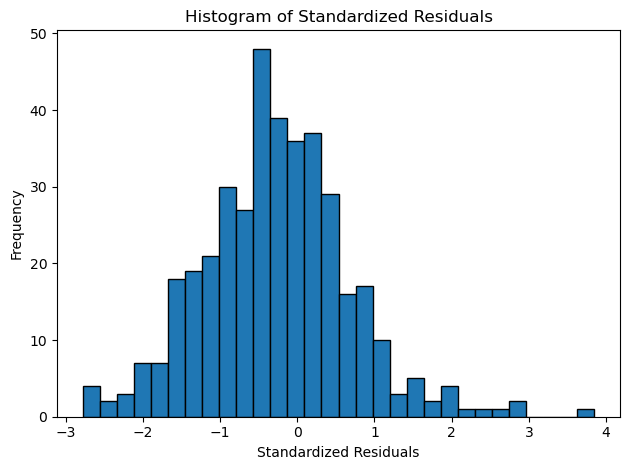

In [67]:
residuals_histogramm = plt.hist(standardized_residuals, bins=30, edgecolor='k')
plt.title("Histogram of Standardized Residuals")
plt.xlabel("Standardized Residuals")
plt.ylabel("Frequency")

plt.tight_layout()
plt.gcf().savefig(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Abbildungen\(11) Fahrraddaten_HyperparameterTuning4\residuals_histogramm.png")
plt.show()
plt.close()


### Scores

In [68]:
# Calculate prediction intervals (95% confidence interval)
lower_bound = predicted_mean - 1.96 * predicted_std
upper_bound = predicted_mean + 1.96 * predicted_std

# Check how many actual values fall within the prediction interval
coverage = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))

print(f"PICP (Prediction Interval Coverage Probability): {coverage:.2f}")

#picp represents the percentage of actual values that fall within the prediction interval
#97 percent of true values fall within 95% of the prediction interval

PICP (Prediction Interval Coverage Probability): 0.94


In [69]:
brier_scores = np.mean((norm.cdf(y_test, loc=predicted_mean, scale=predicted_std) - 1)**2)
print(f"Brier Score: {brier_scores:.4f}")

Brier Score: 0.4164


### Other

In [70]:
cv_results_df = pd.DataFrame(loaded_grid_search_tuned.cv_results_)

In [71]:
cv_results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_batch_size', 'param_model__dropout_rate',
       'param_model__n_blocks', 'param_model__n_neurons',
       'param_model__reg_value', 'param_optimizer__learning_rate', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [72]:
df_cv_scores = pd.DataFrame(loaded_grid_search_tuned.cv_results_)[['mean_test_score', 'std_test_score']]

In [73]:
df_cv_scores

,mean_test_score,std_test_score
0,-419.548553,39.071017
1,-429.440481,56.177956
2,-441.827983,61.781338
3,-436.141520,42.617425


In [74]:
df_cv_scores_not_negated = df_cv_scores.copy()
df_cv_scores_not_negated['mean_test_score'] = df_cv_scores_not_negated['mean_test_score'] * -1


In [75]:
df_cv_scores_not_negated

,mean_test_score,std_test_score
0,419.548553,39.071017
1,429.440481,56.177956
2,441.827983,61.781338
3,436.141520,42.617425


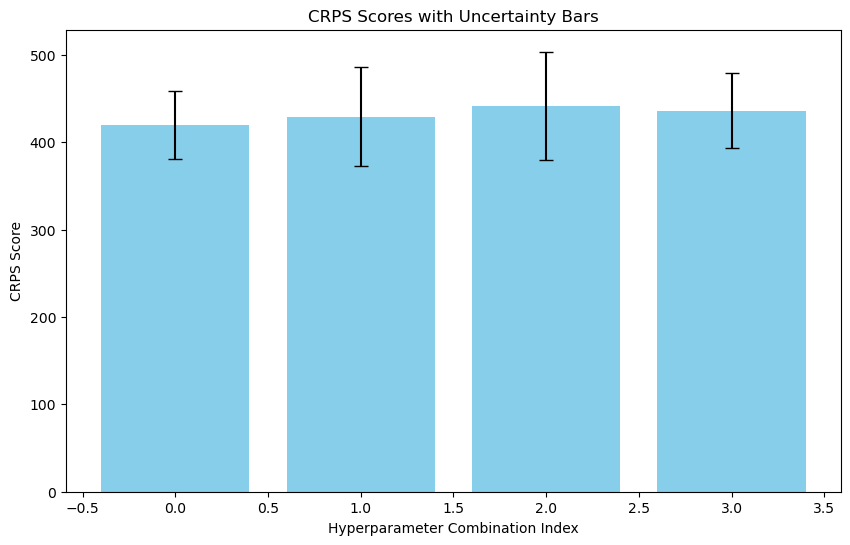

In [76]:
# Plotting with uncertainty bars
plt.figure(figsize=(10, 6))
plt.bar(df_cv_scores_not_negated.index, df_cv_scores_not_negated['mean_test_score'], 
        yerr=df_cv_scores_not_negated['std_test_score'], capsize=5, color='skyblue')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('CRPS Score')
plt.title('CRPS Scores with Uncertainty Bars')
plt.show()


In [77]:
df_cv_scores

,mean_test_score,std_test_score
0,-419.548553,39.071017
1,-429.440481,56.177956
2,-441.827983,61.781338
3,-436.141520,42.617425


In [78]:
loaded_grid_search_tuned.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=3,
             estimator=KerasRegressor(epochs=200, model=<function tune_nn.<locals>.create_model at 0x00000198A3ED93A0>, verbose=0),
             n_jobs=1,
             param_grid={'batch_size': [32], 'model__dropout_rate': [0.25],
                         'model__n_blocks': [2, 4, 5, 6],
                         'model__n_neurons': [256], 'model__reg_value': [0.01],
                         'optimizer__learning_rate': [0.0001]},
             scoring=make_scorer(crps_loss_function_wrapper, greater_is_better=False, response_method='predict'),
             verbose=10)>

In [79]:
cv_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_model__dropout_rate,param_model__n_blocks,param_model__n_neurons,param_model__reg_value,param_optimizer__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,46.959154,2.164338,0.168518,0.002673,32,0.25,2,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-436.033295,-365.633362,-456.979004,-419.548553,39.071017,1
1,68.182266,7.563303,0.287832,0.051228,32,0.25,4,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-433.128113,-358.867157,-496.326172,-429.440481,56.177956,2
2,67.854870,4.217442,0.226690,0.004473,32,0.25,5,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-435.055481,-369.775513,-520.652954,-441.827983,61.781338,4
3,71.661458,1.339978,0.266316,0.013437,32,0.25,6,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-438.290680,-382.904663,-487.229218,-436.141520,42.617425,3


In [80]:
cv_results_df['mean_test_score'] = cv_results_df['mean_test_score'] * -1

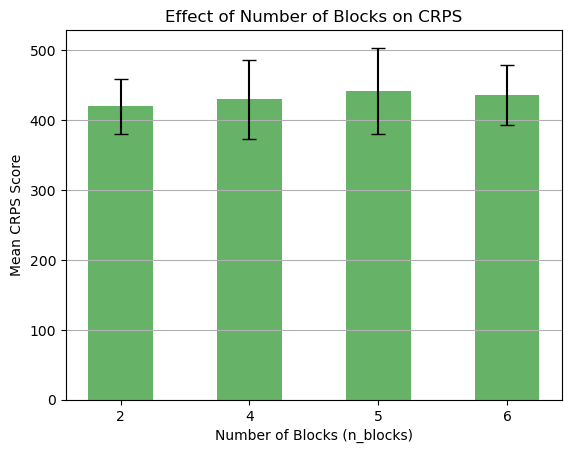

In [81]:
n_blocks_values = cv_results_df['param_model__n_blocks'].unique()
mean_crps_n_blocks = [cv_results_df[cv_results_df['param_model__n_blocks'] == nb]['mean_test_score'].mean() for nb in n_blocks_values]
std_crps_n_blocks = [cv_results_df[cv_results_df['param_model__n_blocks'] == nb]['std_test_score'].mean() for nb in n_blocks_values]

bar_width = 0.4  
index = np.arange(len(n_blocks_values))  *0.8

plt.bar(index, mean_crps_n_blocks, yerr=std_crps_n_blocks, capsize=5, color='green', alpha=0.6, width=bar_width, label="n_blocks")

plt.title("Effect of Number of Blocks on CRPS")
plt.xlabel("Number of Blocks (n_blocks)")
plt.ylabel("Mean CRPS Score")
plt.xticks(index, n_blocks_values)  
plt.grid(True, axis='y')
plt.show()


In [82]:
loaded_grid_search_tuned.best_params_

{'batch_size': 32,
 'model__dropout_rate': 0.25,
 'model__n_blocks': 2,
 'model__n_neurons': 256,
 'model__reg_value': 0.01,
 'optimizer__learning_rate': 0.0001}

In [83]:
model.model_.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_72 (Dense)                │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,904 (816.04 KB)

 Trainable params: 69,634 (272.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 139,270 (544.03 KB)